/var/folders/1r/xbh8qf_s1cb25q4t_1_v4bzh0000gn/T/ipykernel_86973/476747465.py:22: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


✅ Run 1: ROI = -1.51%, Profit = $-776.66, Accuracy = 0.6799
✅ Run 2: ROI = -7.16%, Profit = $-3839.32, Accuracy = 0.6757
✅ Run 3: ROI = -8.61%, Profit = $-4062.00, Accuracy = 0.6797
✅ Run 4: ROI = -6.60%, Profit = $-3443.32, Accuracy = 0.6799
✅ Run 5: ROI = -6.43%, Profit = $-3021.99, Accuracy = 0.6745
✅ Run 6: ROI = -10.34%, Profit = $-4200.00, Accuracy = 0.6777
✅ Run 7: ROI = -2.01%, Profit = $-1019.32, Accuracy = 0.6753
✅ Run 8: ROI = 2.21%, Profit = $1224.01, Accuracy = 0.6795
✅ Run 9: ROI = -8.87%, Profit = $-4080.00, Accuracy = 0.6823
✅ Run 10: ROI = -7.04%, Profit = $-3536.00, Accuracy = 0.6731


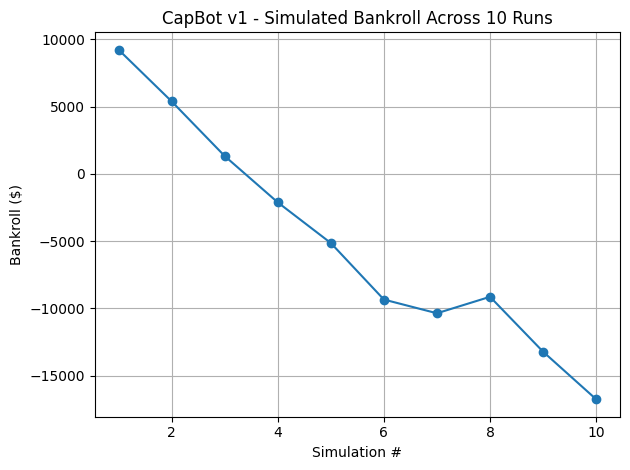

📄 README saved to /Users/boroni_4/Documents/CapBot/capbot/notebooks/versions/v1/CapBot_v1_README.md
📊 XLSX Report saved to /Users/boroni_4/Documents/CapBot/capbot/notebooks/versions/v1/CapBot_v1_Report_20250516.xlsx


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from datetime import datetime
from pathlib import Path
import os

# === Dynamic Path Setup ===
notebook_dir = Path(__file__).parent if "__file__" in globals() else Path().resolve()
version = "v1"
today = datetime.today().strftime("%Y%m%d")
version_dir = notebook_dir
summary_path = version_dir / f"summary_{version}.csv"
summary_xlsx_path = version_dir / f"CapBot_{version}_Report_{today}.xlsx"
readme_path = version_dir / f"CapBot_{version}_README.md"

# === Load Data ===
file_path = version_dir / "../../../data/historical/processed/matches_2015_2025_combined_balanced.csv"
df = pd.read_csv(file_path)
numeric_cols = ['rank_A', 'rank_B', 'pts_A', 'pts_B', 'odds_A', 'odds_B']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())
df = df.dropna(subset=numeric_cols + ['winner_code'])

# === Run 10 Simulations ===
all_stats = []
all_bets_dfs = []

for run in range(1, 11):
    X = df[numeric_cols]
    y = df['winner_code']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, stratify=y, random_state=run
    )

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    preds_proba = model.predict_proba(X_test)[:, 1]
    preds = (preds_proba > 0.5).astype(int)
    accuracy = accuracy_score(y_test, preds)

    test_df = X_test.copy()
    test_df["pred_proba"] = preds_proba
    test_df["predicted"] = preds
    test_df["correct"] = (preds == y_test).astype(int)
    test_df["bet"] = 200
    test_df["target"] = y_test.values

    meta_cols = ['date', 'player_A', 'player_B', 'odds_A']
    for col in meta_cols:
        if col not in df.columns:
            df[col] = np.nan
    cols_to_add = [col for col in meta_cols if col not in test_df.columns]
    test_df = test_df.join(df.loc[test_df.index, cols_to_add])

    bets = test_df[(test_df["pred_proba"] >= 0.60) & (test_df["odds_A"] >= 1.50)]
    bets = bets[["date", "player_A", "player_B", "odds_A", "pred_proba", "target"]].copy()
    bets.loc[:, "profit"] = np.where(
        bets["target"] == 1,
        200 * (bets["odds_A"] - 1),
        -200
    )
    bets["Run"] = run
    all_bets_dfs.append(bets)

    total_bets = len(bets)
    total_profit = bets["profit"].sum()
    roi = (total_profit / (200 * total_bets)) * 100 if total_bets else 0
    bet_accuracy = (bets['target'] == (bets['pred_proba'] > 0.5).astype(int)).mean() if total_bets else 0

    all_stats.append({
        "Run": run,
        "Accuracy": round(accuracy, 4),
        "Total Bets": total_bets,
        "Profit ($)": round(total_profit, 2),
        "ROI (%)": round(roi, 2),
        "Bet Accuracy": round(bet_accuracy, 4)
    })

    print(f"✅ Run {run}: ROI = {roi:.2f}%, Profit = ${total_profit:.2f}, Accuracy = {accuracy:.4f}")

# === Summary CSV Output ===
df_stats = pd.DataFrame(all_stats)
average_row = {
    "Run": "Average",
    "Accuracy": round(df_stats["Accuracy"].mean(), 4),
    "Total Bets": int(df_stats["Total Bets"].mean()),
    "Profit ($)": round(df_stats["Profit ($)"].mean(), 2),
    "ROI (%)": round(df_stats["ROI (%)"].mean(), 2),
    "Bet Accuracy": round(df_stats["Bet Accuracy"].mean(), 4)
}
df_stats.loc[len(df_stats)] = average_row
df_stats.to_csv(summary_path, index=False)

# === Write XLSX Report with bets + summary ===
with pd.ExcelWriter(summary_xlsx_path, engine="xlsxwriter") as writer:
    df_stats.to_excel(writer, sheet_name="Summary", index=False)
    all_bets = pd.concat(all_bets_dfs, ignore_index=True)
    all_bets.to_excel(writer, sheet_name="All Bets", index=False)
    writer.sheets["All Bets"].write(len(all_bets) + 2, 4, "Total Bets")
    writer.sheets["All Bets"].write(len(all_bets) + 2, 5, len(all_bets))
    writer.sheets["All Bets"].write(len(all_bets) + 3, 4, "Total Profit")
    writer.sheets["All Bets"].write(len(all_bets) + 3, 5, all_bets["profit"].sum())

# === Plot ===
bankrolls = [10000 + sum([s["Profit ($)"] for s in all_stats[:i+1]]) for i in range(len(all_stats))]
plt.plot(range(1, 11), bankrolls, marker='o')
plt.title("CapBot v1 - Simulated Bankroll Across 10 Runs")
plt.xlabel("Simulation #")
plt.ylabel("Bankroll ($)")
plt.grid()
plt.tight_layout()
plt.show()

# === README Output ===
conf_matrix = confusion_matrix(y_test, preds)
conf_matrix_str = "\n".join(["\t".join(map(str, row)) for row in conf_matrix])
stats_md = df_stats.to_markdown(index=False)

readme = f"""\
# 📄 CapBot {version} – Release Notes

**Date:** {today}  
**Summary File:** `{summary_path.name}`  
**Excel Report:** `{summary_xlsx_path.name}`  
**Model Version:** {version}  
**Strategy Version:** {version}  

---

## 🧠 Model Info
- **Type:** Logistic Regression (`sklearn`)
- **Train/Test Split:** 75/25 stratified (10 different seeds)
- **Features Used:**  `rank_A`, `rank_B`, `pts_A`, `pts_B`, `odds_A`, `odds_B`
- **Target:** `winner_code` → 1 = Player A wins, 0 = Player B wins

---

## 📂 Dataset
- **Source File:** `{file_path}`
- **Filtered Rows (after cleanup):** {len(df)}

---

## 📊 Last Run Snapshot
- **Accuracy:** {accuracy:.4f}  
- **Confusion Matrix:**
```
{conf_matrix_str}
```

---

## 💸 Betting Strategy
- Bet if `pred_proba >= 0.60` and `odds_A >= 1.50`
- Flat bet of $200 per match

---

## 📈 10 Simulation Summary

{stats_md}

---

## ✅ Notes
- v1 is the benchmark with no external features, EV filters, or parlay logic yet.
- Future versions will include EV logic, SHAP explainability, bankroll optimization.

---
"""

with open(readme_path, "w", encoding="utf-8") as f:
    f.write(readme)

print(f"📄 README saved to {readme_path.resolve()}")
print(f"📊 XLSX Report saved to {summary_xlsx_path.resolve()}")
